In [5]:
!conda install -y dask distributed 

Channels:
 - defaults
 - conda-forge
 - pytorch
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/Caskroom/miniconda/base

  added / updated specs:
    - dask
    - distributed


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arrow-cpp-11.0.0           |  hce30654_42_cpu          37 KB  conda-forge
    aws-c-auth-0.7.4           |       h3e84773_2          85 KB  conda-forge
    aws-c-cal-0.6.2            |       h12c43c8_2          35 KB  conda-forge
    aws-c-common-0.9.3         |       hb547adb_0         201 KB  conda-forge
    aws-c-compression-0.2.17   |       h12c43c8_3          18 KB  conda-forge
    aws-c-event-stream-0.3.2   |       h8f67f9a_2          46 KB  conda-forge
    aws-c-http-0.7.13          |       h7dae168_2         147 KB  conda-forge
    aws-c-io-0.13.33           |       h5bd1e48_0         134 KB  conda-forg

In [7]:
from dask.distributed import Client, progress

In [8]:
client = Client(processes=False, threads_per_worker=4,
                n_workers=4, memory_limit='2GB')

In [9]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://25.36.10.142:8787/status,
Dashboard: http://25.36.10.142:8787/status,Workers: 4
Total threads: 16,Total memory: 7.45 GiB
Status: running,Using processes: False
Comm: inproc://25.36.10.142/88412/1,Workers: 4
Dashboard: http://25.36.10.142:8787/status,Total threads: 16
Started: Just now,Total memory: 7.45 GiB
Comm: inproc://25.36.10.142/88412/4,Total threads: 4
Dashboard: http://25.36.10.142:51571/status,Memory: 1.86 GiB
Nanny: None,


In [25]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [15]:
X, y = make_classification(n_samples=3000, random_state=0)
X[:5]

array([[-0.01584224, -1.17071325,  0.22107442,  0.57803056,  0.1053591 ,
        -0.03932824,  0.26151967, -0.95510987,  0.71961772, -0.9383911 ,
         0.7425605 ,  0.38059701, -1.76514569, -0.83457088,  0.57154435,
        -0.67335197, -0.49464181,  0.70312324,  1.47841811, -0.13301105],
       [-1.56007734, -0.64061722, -1.1436108 ,  0.75130989, -0.4437953 ,
        -0.59093729,  1.49000541, -0.60309112, -1.92916019,  0.03394084,
         0.46294119,  0.09798406,  1.21153433, -1.37380366, -0.05310303,
        -0.31788403, -0.78350621, -0.06859022, -0.8120594 ,  0.18571232],
       [ 0.87967465,  0.78606501, -0.07580891, -0.15728215,  0.72911878,
        -0.20169824, -2.48362196, -0.03820355,  0.50205159,  0.0290385 ,
        -0.23527074,  1.20655642,  0.11236841, -0.1255825 , -0.56081837,
         3.2665983 ,  0.24856024,  1.28270091,  0.75680091, -0.00978306],
       [-0.10526457, -0.71207282,  1.21701078,  0.66873524,  0.81071941,
        -0.71375545,  0.47856421,  0.99261999,  

In [16]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

In [17]:
# Fit normaly with
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]})

In [18]:
# fit with cluster
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

In [20]:
!pip install dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00


In [5]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.cluster import KMeans

In [6]:
X, y = make_blobs(n_samples=10000000,
                  random_state=0,
                  centers=3)

In [7]:
km = KMeans(n_clusters=3)
km.fit(X)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [8]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [15]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

In [16]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

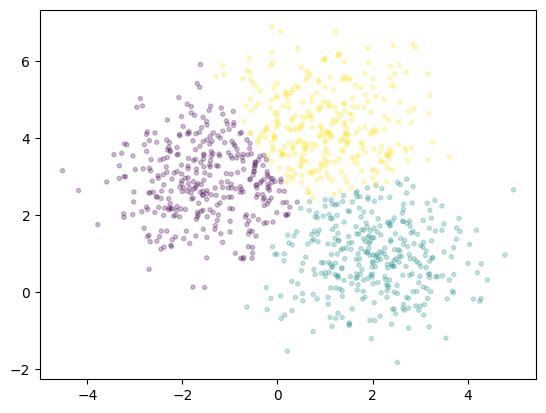

In [17]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);